In [1]:
import sys
sys.path.append('..')
from dataset import CatDogDataModule

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset exploration and visualizations
This notebook loads the Cat vs Dog dataset using `CatDogDataModule` and produces a set of visualizations

Adjust `SAMPLE_LIMIT` and `EMBED_SAMPLE` if you want faster or deeper runs.

In [2]:
# Setup data module and configuration
import os
from types import SimpleNamespace
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from tqdm import tqdm

repo_root = os.path.abspath(os.path.join('..', '..'))
data_dir = os.path.join(repo_root, 'data', 'PetImages')
print('repo_root', repo_root)
print('data_dir', data_dir)

dm = CatDogDataModule(data_dir=data_dir, batch_size=32, num_workers=2)
dm.setup() 
train_ds = dm.train_dataset
val_ds = dm.val_dataset
full_ds = train_ds.dataset if hasattr(train_ds, 'dataset') else train_ds
print('Full dataset size (samples):', len(full_ds))
print('Train / Val sizes:', len(train_ds), len(val_ds))
print('Classes:', full_ds.classes)

repo_root /mnt/Fedora2/code/isef/ImageCompression
data_dir /mnt/Fedora2/code/isef/ImageCompression/data/PetImages
Full dataset size (samples): 24959
Train / Val sizes: 22463 2496
Classes: ['Cat', 'Dog']


Counter({'cat': 12490, 'dog': 12469})


/tmp/ipykernel_95208/2000907952.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=counts, palette='pastel')


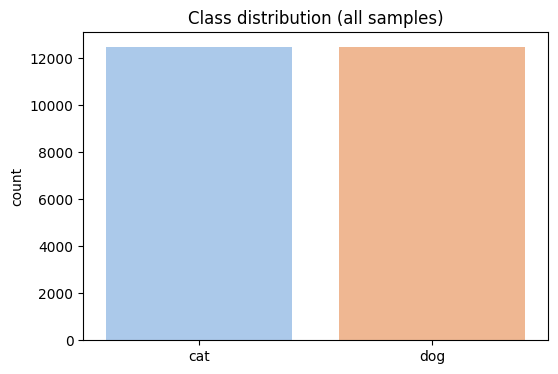

In [3]:
# Class distribution bar plot
from collections import Counter
labels = [full_ds.classes[label] for _, label in full_ds.samples]
counter = Counter([l.lower() for l in labels])
print(counter)
names = list(counter.keys())
counts = [counter[n] for n in names]
plt.figure(figsize=(6,4))
sns.barplot(x=names, y=counts, palette='pastel')
plt.title('Class distribution (all samples)')
plt.ylabel('count')
plt.show()

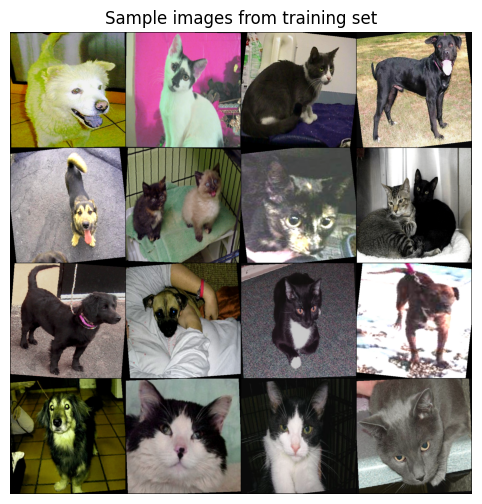

First batch labels ([1.0, 0.0] = Cat, [0.0, 1.0] = Dog): [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]


In [4]:
import torch
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
batch = next(iter(dl))
imgs, labs = batch
grid = make_grid(imgs, nrow=4, padding=2)
plt.figure(figsize=(10,6))
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.axis('off')
plt.title('Sample images from training set')
plt.show()

print('First batch labels ([1.0, 0.0] = Cat, [0.0, 1.0] = Dog):', labs.tolist())

reading sizes:  92%|█████████▏| 22886/24959 [00:00<00:00, 25145.63it/s]/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
reading sizes: 100%|██████████| 24959/24959 [00:00<00:00, 25282.65it/s]


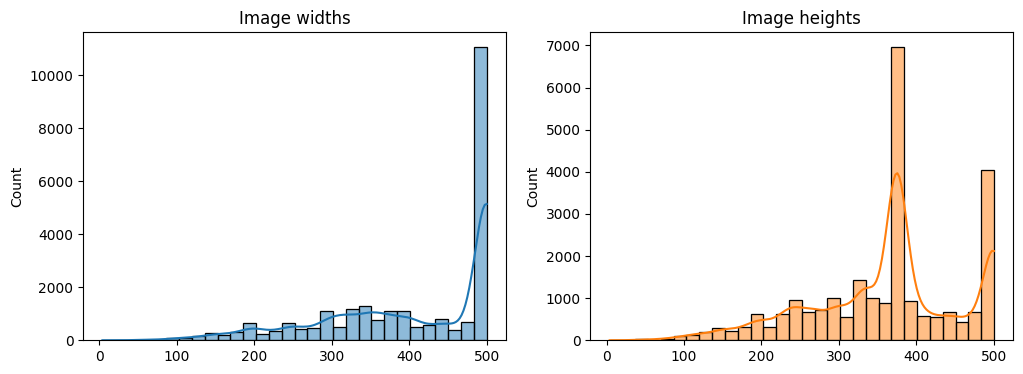

In [5]:
widths = []
heights = []
paths = [p for p, _ in full_ds.samples]
for p in tqdm(paths, desc='reading sizes'):
    with Image.open(p) as im:
        w,h = im.size
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(widths, bins=30, kde=True, color='tab:blue')
plt.title('Image widths')
plt.subplot(1,2,2)
sns.histplot(heights, bins=30, kde=True, color='tab:orange')
plt.title('Image heights')
plt.show()

channel stats: 100%|██████████| 500/500 [00:02<00:00, 201.10it/s]

Channel means (R,G,B): [0.48852303 0.45194065 0.41743135]
Channel stds  (R,G,B): [0.22983796 0.22900449 0.22850943]



/tmp/ipykernel_95208/2013752168.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['R','G','B'], y=means, palette=['#e74c3c','#27ae60','#3498db'])


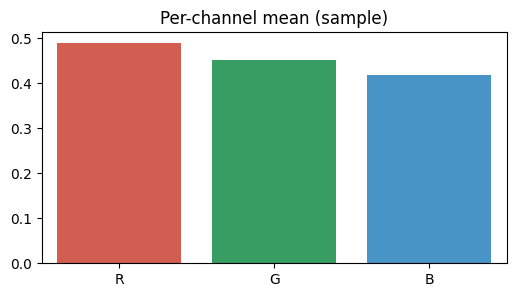

In [6]:
CHANNEL_SAMPLE = 500
means = np.zeros(3)
stds = np.zeros(3)
count = 0
for p, _ in tqdm(full_ds.samples[:CHANNEL_SAMPLE], desc='channel stats'):
    try:
        im = Image.open(p).convert('RGB')
        arr = np.array(im).astype(np.float32)/255.0
        means += arr.mean(axis=(0,1))
        stds += arr.std(axis=(0,1))
        count += 1
    except Exception:
        continue

means /= max(1, count)
stds /= max(1, count)
print('Channel means (R,G,B):', means)
print('Channel stds  (R,G,B):', stds)

plt.figure(figsize=(6,3))
sns.barplot(x=['R','G','B'], y=means, palette=['#e74c3c','#27ae60','#3498db'])
plt.title('Per-channel mean (sample)')
plt.show()